# Práctica Multiobjetivo – MW7


In [4]:
import numpy as np
import random, copy
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from pymoo.indicators.hv import Hypervolume

Se inicializa el problema MW7 de la suite MW, obteniendo automáticamente el número de variables y sus límites. Además, se fija un presupuesto total de evaluaciones y un tamaño de población, a partir del cual se deriva el número de generaciones.

In [2]:
problem = get_problem('mw7')  # MW7 (suite MW) - variables en el rango definido por el problema
N_VAR = problem.n_var
XL, XU = problem.xl, problem.xu

BUDGET = 10_000
POP_SIZE = 100
N_GEN = BUDGET // POP_SIZE  # 100 gen -> 10k evals

## Funciones auxiliares

Crear la población:

In [ ]:
def create_population_mo(pop_size=POP_SIZE):
    return np.random.uniform(XL, XU, size=(pop_size, N_VAR))

La función `eval_pop` evalúa una población de soluciones devolviendo los valores de los objetivos y una medida escalar. Su objetivo es separar claramente calidad (objetivos) y factibilidad.

In [ ]:
def eval_pop(X, eps_eq=1e-4):
    out = problem.evaluate(X, return_values_of=['F', 'G', 'H'])

    if isinstance(out, (tuple, list)):
        F = out[0]
        G = out[1] if len(out) > 1 else None
        H = out[2] if len(out) > 2 else None
    else:
        F, G, H = out, None, None

    CV = np.zeros(len(F), dtype=float)

    if G is not None:
        G = np.asarray(G)
        if G.ndim == 1:
            G = G[:, None]
        CV += np.sum(np.maximum(G, 0.0), axis=1)

    if H is not None:
        H = np.asarray(H)
        if H.ndim == 1:
            H = H[:, None]
        CV += np.sum(np.maximum(np.abs(H) - eps_eq, 0.0), axis=1)

    return F, CV

Este método asigna rangos de Pareto a las soluciones. Las soluciones factibles se ordenan por dominancia, mientras que las no factibles se consideran peores y se ordenan según su violación de restricciones.

In [ ]:
def nd_ranks(F, CV=None):
    N = len(F)
    if CV is None:
        CV = np.zeros(N)

    feas = (CV == 0)
    fronts_all = []
    rank = np.full(N, fill_value=10**9, dtype=int)

    # 1) Factibles: ND sorting normal
    if np.any(feas):
        nds = NonDominatedSorting()
        fronts_feas = nds.do(F[feas])
        feas_idx = np.where(feas)[0]
        for r, front in enumerate(fronts_feas):
            real_idx = feas_idx[front]
            fronts_all.append(real_idx)
            rank[real_idx] = r
        next_rank = len(fronts_feas)
    else:
        next_rank = 0

    # 2) No factibles: ordenar por CV
    infeas_idx = np.where(~feas)[0]
    if len(infeas_idx) > 0:
        order = infeas_idx[np.argsort(CV[infeas_idx])]
        fronts_all.append(order)   
        rank[order] = next_rank

    return fronts_all, rank

Calcula una medida de densidad dentro de un frente de Pareto. Buscamos mantener diversidad entre soluciones con el mismo rango, favoreciendo aquellas que están en regiones menos pobladas del espacio de objetivos.

In [ ]:
def crowding_distance(F_front):
    k = len(F_front)
    if k == 0:
        return np.array([])
    if k <= 2:
        return np.full(k, np.inf)

    m = F_front.shape[1]
    cd = np.zeros(k, dtype=float)

    for j in range(m):
        order = np.argsort(F_front[:, j])
        cd[order[0]] = np.inf
        cd[order[-1]] = np.inf

        fmin = F_front[order[0], j]
        fmax = F_front[order[-1], j]
        if fmax == fmin:
            continue

        for t in range(1, k - 1):
            if np.isinf(cd[order[t]]):
                continue
            prevv = F_front[order[t - 1], j]
            nextv = F_front[order[t + 1], j]
            cd[order[t]] += (nextv - prevv) / (fmax - fmin)

    return cd

## Métricas

Implementamos $3$ métricas (hipervolumen, dispersión y espaciado) para tener como refencia en nuestros experimentos. 

In [3]:
def calculate_metrics(front, ref_point):
    metricHV = Hypervolume(ref_point)
    hv = metricHV.do(front)

    min_values = np.min(front, axis=0)
    max_values = np.max(front, axis=0)
    spr = np.mean(max_values - min_values)

    d = np.linalg.norm(front[:, None, :] - front[None, :, :], axis=-1)
    np.fill_diagonal(d, np.inf)
    spa = np.mean(np.min(d, axis=1))

    return hv, spr, spa

## NSGA-II y SPEA2 (pymoo) con el mismo budget

En primer lugar, se filtra el frente no dominado priorizando soluciones factibles y, si no existen, aquellas con menor violación de restricciones, garantizando así un conjunto de soluciones representativo. A continuación, se ejecutan NSGA-II y SPEA2 con configuraciones comparables, obteniendo la población final, las violaciones de restricciones y el frente de Pareto aproximado.

In [5]:
def _filter_nd_feasible(F, CV=None):
    F = np.asarray(F)
    if CV is None:
        nd = NonDominatedSorting().do(F, only_non_dominated_front=True)
        return F[nd]

    CV = np.asarray(CV).reshape(-1)
    feas = (CV == 0)
    if np.any(feas):
        Ff = F[feas]
        nd = NonDominatedSorting().do(Ff, only_non_dominated_front=True)
        return Ff[nd]
    else:
        # sin factibles: devolvemos un subconjunto con menor CV
        idx = np.argsort(CV)[:min(len(CV), 100)]
        return F[idx]


def run_nsga2(seed=0, pop_size=POP_SIZE, n_gen=N_GEN):
    algo = NSGA2(
        pop_size=pop_size,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(prob=1.0/N_VAR, eta=20),
        eliminate_duplicates=True
    )
    res = minimize(problem, algo, ('n_gen', n_gen), seed=seed, verbose=False)

    F = res.pop.get('F')
    # --- obtener CV de forma robusta (compatible con distintas versiones de pymoo) ---
    CV = res.pop.get("CV")
    if CV is not None:
        CV = np.asarray(CV)
        if CV.ndim == 2:
            CV = CV.sum(axis=1)
        CV = CV.reshape(-1)
    F_nd = _filter_nd_feasible(F, CV)
    return {"F": F, "CV": CV, "F_nd": F_nd}


def run_spea2(seed=0, pop_size=POP_SIZE, n_gen=N_GEN):
    algo = SPEA2(
        pop_size=pop_size,
        sampling=FloatRandomSampling(),
        crossover=SBX(prob=0.9, eta=15),
        mutation=PM(prob=1.0/N_VAR, eta=20),
        eliminate_duplicates=True
    )
    res = minimize(problem, algo, ('n_gen', n_gen), seed=seed, verbose=False)

    F = res.pop.get('F')
    CV = res.pop.get("CV")
    if CV is not None:
        CV = np.asarray(CV)
        if CV.ndim == 2:
            CV = CV.sum(axis=1)
        CV = CV.reshape(-1)


    F_nd = _filter_nd_feasible(F, CV)
    return {"F": F, "CV": CV, "F_nd": F_nd}


## Primer experimento

### Cruce

Realiza una interpolación lineal entre ambos padres. Operador más explotativo.

In [ ]:
def arithmetic_crossover_vec(p1, p2, pcross=0.9):
    if random.random() > pcross:
        return p1.copy(), p2.copy()
    alpha = random.random()
    c1 = alpha * p1 + (1 - alpha) * p2
    c2 = (1 - alpha) * p1 + alpha * p2

    c1 = np.clip(c1, np.asarray(XL), np.asarray(XU))
    c2 = np.clip(c2, np.asarray(XL), np.asarray(XU))
    return c1, c2

### Mutación

Aplica perturbaciones siguiendo una distribución normal, proporcionando un compromiso entre exploración y explotación.

In [ ]:
def gaussian_mutation_vec(x, pmut=None, sigma=0.1):
    if pmut is None:
        pmut = 1.0 / N_VAR
    y = x.copy()
    for i in range(len(y)):
        if random.random() < pmut:
            y[i] += random.gauss(0, sigma)

    XL_arr = np.asarray(XL)
    XU_arr = np.asarray(XU)
    return np.clip(y, XL_arr, XU_arr)

### Selección

La selección ambiental construye la nueva población priorizando soluciones factibles y mejor posicionadas en los frentes de Pareto, utilizando la distancia de crowding para mantener diversidad y recurriendo a la violación de restricciones cuando aparecen soluciones no factibles. Por otro lado, la selección por torneo aplica reglas jerárquicas basadas en factibilidad, rango de Pareto, crowding y violación de restricciones, asegurando que el proceso de reproducción favorezca soluciones factibles, no dominadas y bien distribuidas

In [ ]:
def environmental_selection(pop, F, CV, pop_size=POP_SIZE):
    fronts, rank = nd_ranks(F, CV)

    new_idx = []
    crowd = np.zeros(len(pop), dtype=float)

    for front in fronts:
        front = np.asarray(front, dtype=int)

        if np.any(CV[front] > 0):
            order = np.argsort(CV[front])         
            front_sorted = front[order]
            remaining = pop_size - len(new_idx)
            if remaining <= 0:
                break
            chosen = front_sorted[:remaining]
            new_idx.extend(chosen.tolist())
            break

        if len(new_idx) + len(front) <= pop_size:
            cd = crowding_distance(F[front])
            crowd[front] = cd
            new_idx.extend(front.tolist())
        else:
            cd = crowding_distance(F[front])
            crowd[front] = cd
            remaining = pop_size - len(new_idx)
            order = np.argsort(-cd)
            chosen = front[order[:remaining]]
            new_idx.extend(chosen.tolist())
            break

    new_idx = np.array(new_idx, dtype=int)
    return pop[new_idx], F[new_idx], CV[new_idx], rank[new_idx], crowd[new_idx]

def tournament_select(pop, rank, crowd, CV):
    i, j = random.randrange(len(pop)), random.randrange(len(pop))

    fi = (CV[i] == 0)
    fj = (CV[j] == 0)

    if fi and not fj:
        return pop[i]
    if fj and not fi:
        return pop[j]
    if (not fi) and (not fj):
        return pop[i] if CV[i] < CV[j] else pop[j]

    # ambos factibles
    if rank[i] < rank[j]:
        return pop[i]
    if rank[j] < rank[i]:
        return pop[j]
    return pop[i] if crowd[i] > crowd[j] else pop[j]

### Evolución

A partir de una población inicial aleatoria, las soluciones se evalúan y se seleccionan mediante un esquema ambiental que prioriza factibilidad, dominancia de Pareto y diversidad. En cada generación, se generan hjijos mediante selección por torneo, cruce aritmético y mutación gaussiana, integrándolos con la población actual antes de aplicar nuevamente la selección ambiental. El proceso se repite durante un número fijo de generaciones y finaliza extrayendo un frente no dominado representativo, devolviendo así una aproximación del frente de Pareto junto con el número total de evaluaciones realizadas.

In [ ]:
def evolve_my_mo(seed=0, pop_size=POP_SIZE, n_gen=N_GEN, pcross=0.9, pmut=None, sigma=0.1):
    random.seed(seed)
    np.random.seed(seed)

    pop = create_population_mo(pop_size)
    F, CV = eval_pop(pop)
    evals = pop_size

    pop, F, CV, rank, crowd = environmental_selection(pop, F, CV, pop_size)

    for _ in range(n_gen):
        children = []
        while len(children) < pop_size:
            p1 = tournament_select(pop, rank, crowd, CV)
            p2 = tournament_select(pop, rank, crowd, CV)
            c1, c2 = arithmetic_crossover_vec(p1, p2, pcross)
            c1 = gaussian_mutation_vec(c1, pmut=pmut, sigma=sigma)
            c2 = gaussian_mutation_vec(c2, pmut=pmut, sigma=sigma)
            children.append(c1)
            if len(children) < pop_size:
                children.append(c2)

        children = np.array(children)
        Fc, CVc = eval_pop(children)
        evals += pop_size

        pop = np.vstack([pop, children])
        F = np.vstack([F, Fc])
        CV = np.hstack([CV, CVc])

        pop, F, CV, rank, crowd = environmental_selection(pop, F, CV, pop_size)

    # Frente ND final (priorizando factibles)
    feas = (CV == 0)
    if np.any(feas):
        Ff = F[feas]
        nd = NonDominatedSorting().do(Ff, only_non_dominated_front=True)
        F_nd = Ff[nd]
    else:
        # si no hay factibles, devolvemos puntos con menor CV
        idx = np.argsort(CV)[:min(len(CV), pop_size)]
        F_nd = F[idx]

    return {"pop": pop, "F": F, "CV": CV, "F_nd": F_nd, "evals": evals}

### Experimento único

Comparamos nuestro algortimos genético con los resultados obtenidos por NSGA-II y SPEA2:

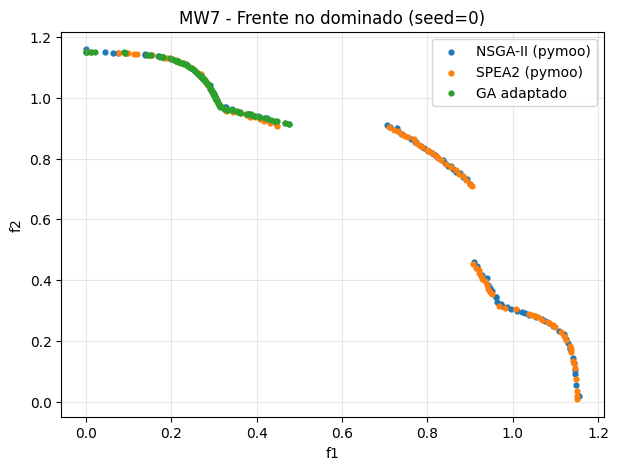

In [47]:
seed = 0

my = evolve_my_mo(seed=seed)
ns = run_nsga2(seed=seed)
sp = run_spea2(seed=seed)

plt.figure(figsize=(7,5))
plt.scatter(ns["F_nd"][:,0], ns["F_nd"][:,1], s=12, label="NSGA-II (pymoo)")
plt.scatter(sp["F_nd"][:,0], sp["F_nd"][:,1], s=12, label="SPEA2 (pymoo)")
plt.scatter(my["F_nd"][:,0], my["F_nd"][:,1], s=12, label="GA adaptado")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("MW7 - Frente no dominado (seed=0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Parecen muy prometedores, nuestro algortimo genético se asemeja a NSGA-II y SPEA2.

### Métricas finales

Para distintas semillas aleatorias, se obtiene el frente no dominado de cada algoritmo y se evalúa mediante tres métricas estándar: hipervolumen, dispersión y espaciado, utilizando un mismo punto de referencia. Los resultados de cada ejecución se almacenan en un DataFrame de pandas, lo que permite analizar estadísticamente y comparar de forma objetiva el rendimiento y la calidad de los frentes.

In [48]:
import pandas as pd

ref_point = np.array([1.2, 1.2])
rows = []

for seed in range(10):
    ag = evolve_my_mo(seed=seed)
    ns = run_nsga2(seed)
    sp = run_spea2(seed)

    hv_ag, spr_ag, spa_ag = calculate_metrics(ag["F_nd"], ref_point)
    hv_n,  spr_n,  spa_n  = calculate_metrics(ns["F_nd"], ref_point)
    hv_s,  spr_s,  spa_s  = calculate_metrics(sp["F_nd"], ref_point)

    rows.append({
        "seed": seed,
        "HV_AG": hv_ag, "SPR_AG": spr_ag, "SPA_AG": spa_ag,
        "HV_NSGA2": hv_n, "SPR_NSGA2": spr_n, "SPA_NSGA2": spa_n,
        "HV_SPEA2": hv_s, "SPR_SPEA2": spr_s, "SPA_SPEA2": spa_s
    })

df = pd.DataFrame(rows)
df


,seed,HV_AG,SPR_AG,SPA_AG,HV_NSGA2,SPR_NSGA2,SPA_NSGA2,HV_SPEA2,SPR_SPEA2,SPA_SPEA2
0,0,0.273646,0.356156,0.003031,0.485366,1.148626,0.010377,0.489135,1.143533,0.011289
1,1,0.268734,0.339781,0.003396,0.481497,1.142147,0.010076,0.474032,1.154737,0.012029
2,2,0.277972,0.345386,0.003401,0.483927,1.147639,0.010861,0.483378,1.130135,0.011297
3,3,0.467416,1.034257,0.008993,0.484740,1.146236,0.010780,0.482797,1.138824,0.011018
4,4,0.261715,0.364809,0.003509,0.465691,1.146128,0.008506,0.480270,1.142831,0.011114
5,5,0.270094,0.335748,0.002776,0.486027,1.136450,0.010540,0.468744,1.162223,0.008448
6,6,0.066191,0.059986,0.000480,0.477643,1.147530,0.008517,0.461806,1.032467,0.007241
7,7,0.361226,0.761768,0.006761,0.480449,1.143449,0.011413,0.483325,1.142132,0.009867
8,8,0.453994,1.026942,0.010047,0.263111,0.124534,0.001371,0.265547,0.152484,0.001671
9,9,0.280189,0.354129,0.002827,0.477383,1.147449,0.010479,0.472427,1.157937,0.011743


#### Estadísticas

In [49]:
summary_hv_spa = df[[
    "HV_AG", "SPA_AG",
    "HV_NSGA2", "SPA_NSGA2",
    "HV_SPEA2", "SPA_SPEA2"
]].agg(["mean", "std"])

summary_hv_spa

,HV_AG,SPA_AG,HV_NSGA2,SPA_NSGA2,HV_SPEA2,SPA_SPEA2
mean,0.298118,0.004522,0.458583,0.009292,0.456146,0.009572
std,0.113054,0.003047,0.068942,0.002942,0.067466,0.003169


### Mejor experimento de AG

Este bloque identifica la mejor ejecución del algoritmo genético propuesto en función del mayor valor de hipervolumen obtenido. A partir de esa semilla, se vuelven a ejecutar el AG adaptado, NSGA-II y SPEA2 para garantizar una comparación justa bajo las mismas condiciones iniciales.

Best seed (AG) = 3


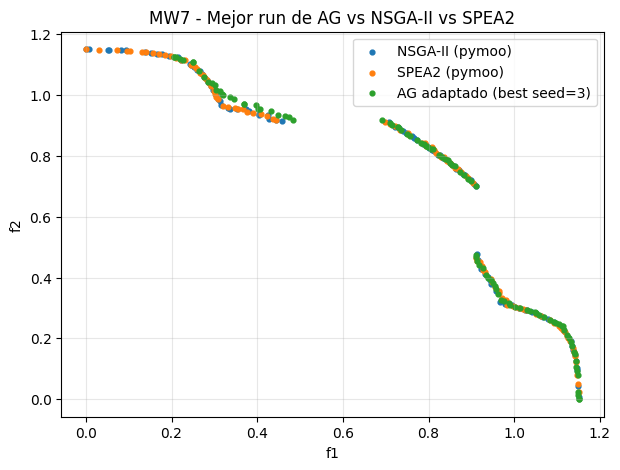

In [50]:
best_seed = int(df.loc[df["HV_AG"].idxmax(), "seed"])
print("Best seed (AG) =", best_seed)

my = evolve_my_mo(seed=best_seed)
ns = run_nsga2(seed=best_seed)
sp = run_spea2(seed=best_seed)

plt.figure(figsize=(7,5))
plt.scatter(ns["F_nd"][:,0], ns["F_nd"][:,1], s=12, label="NSGA-II (pymoo)")
plt.scatter(sp["F_nd"][:,0], sp["F_nd"][:,1], s=12, label="SPEA2 (pymoo)")
plt.scatter(my["F_nd"][:,0], my["F_nd"][:,1], s=12, label=f"AG adaptado (best seed={best_seed})")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("MW7 - Mejor run de AG vs NSGA-II vs SPEA2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Segundo experimento

### Cruce

Probamos otros operadores de cruce, en este caso optamos por el SBX (Simulated Binary Crossover). Busca generar dos descendientes a partir de dos progenitores combinando sus valores de forma controlada, simulando el comportamiento del cruce binario en espacios continuos. El parámetro `eta` regula la dispersión de los descendientes alrededor de los padres, mientras que `pcross` controla la probabilidad de aplicar el cruce.

In [ ]:
def sbx_crossover_vec(p1, p2, pcross=0.9, eta=15):
    if random.random() > pcross:
        return p1.copy(), p2.copy()

    n = len(p1)
    c1 = p1.copy()
    c2 = p2.copy()

    XL_arr = np.asarray(XL)
    XU_arr = np.asarray(XU)

    for i in range(n):
        if random.random() <= 0.5:
            if abs(p1[i] - p2[i]) > 1e-14:
                x1 = min(p1[i], p2[i])
                x2 = max(p1[i], p2[i])
                lb = XL_arr[i]
                ub = XU_arr[i]

                rand = random.random()

                beta = 1.0 + (2.0 * (x1 - lb) / (x2 - x1))
                alpha = 2.0 - beta ** (-(eta + 1.0))
                if rand <= (1.0 / alpha):
                    betaq = (rand * alpha) ** (1.0 / (eta + 1.0))
                else:
                    betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1.0))
                child1 = 0.5 * ((x1 + x2) - betaq * (x2 - x1))

                beta = 1.0 + (2.0 * (ub - x2) / (x2 - x1))
                alpha = 2.0 - beta ** (-(eta + 1.0))
                if rand <= (1.0 / alpha):
                    betaq = (rand * alpha) ** (1.0 / (eta + 1.0))
                else:
                    betaq = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1.0))
                child2 = 0.5 * ((x1 + x2) + betaq * (x2 - x1))

                # mezcla aleatoria para simetría
                if random.random() < 0.5:
                    c1[i] = child2
                    c2[i] = child1
                else:
                    c1[i] = child1
                    c2[i] = child2

    c1 = np.clip(c1, XL_arr, XU_arr)
    c2 = np.clip(c2, XL_arr, XU_arr)
    return c1, c2

### Mutación

Cada gen se perturba con una probabilidad pmut, añadiendo ruido gaussiano cuya desviación estándar es proporcional al rango permitido de la variable.

In [ ]:
def gaussian_mutation_scaled_vec(x, pmut=None, sigma_frac=0.05):
    if pmut is None:
        pmut = 1.0 / N_VAR
    y = x.copy()

    XL_arr = np.asarray(XL)
    XU_arr = np.asarray(XU)
    sig = sigma_frac * (XU_arr - XL_arr)

    for i in range(len(y)):
        if random.random() < pmut:
            y[i] += random.gauss(0.0, float(sig[i]))

    return np.clip(y, XL_arr, XU_arr)

### Evolución

Esta función gestiona un archivo elitista de Pareto que acumula las mejores soluciones encontradas a lo largo de la ejecución. El archivo se actualiza incorporando nuevas soluciones y filtrando aquellas no dominadas, priorizando siempre las soluciones factibles y recurriendo a la violación de restricciones cuando no existen soluciones válidas.

In [ ]:
def pareto_archive_update(A_pop, A_F, A_CV, pop, F, CV, max_size=200):
    if A_pop is None:
        A_pop = pop.copy()
        A_F = F.copy()
        A_CV = CV.copy()
    else:
        A_pop = np.vstack([A_pop, pop])
        A_F   = np.vstack([A_F, F])
        A_CV  = np.hstack([A_CV, CV])

    feas = (A_CV == 0)
    if np.any(feas):
        Ff = A_F[feas]
        idx_feas = np.where(feas)[0]
        nd_local = NonDominatedSorting().do(Ff, only_non_dominated_front=True)
        keep = idx_feas[nd_local]
    else:
        keep = np.argsort(A_CV)[:min(len(A_CV), max_size)]

    A_pop = A_pop[keep]
    A_F   = A_F[keep]
    A_CV  = A_CV[keep]

    if len(A_pop) > max_size:
        cd = crowding_distance(A_F)  
        order = np.argsort(-cd)      
        sel = order[:max_size]
        A_pop = A_pop[sel]
        A_F   = A_F[sel]
        A_CV  = A_CV[sel]

    return A_pop, A_F, A_CV

Nueva versión de evolución, incorporando mecanismos habituales de referencia como el elitismo, cruce SBX y mutación gaussiana escalada al rango de las variables. A lo largo de la evolución, las soluciones se seleccionan mediante un esquema ambiental.

In [ ]:
def evolve_my_mo_v2(seed=0, pop_size=POP_SIZE, n_gen=N_GEN,
                   pcross=0.9, eta_sbx=15,
                   pmut=None, sigma_frac=0.05,
                   archive_size=200):
    random.seed(seed)
    np.random.seed(seed)

    pop = create_population_mo(pop_size)
    pop = np.clip(pop, np.asarray(XL), np.asarray(XU))
    F, CV = eval_pop(pop)
    evals = pop_size

    pop, F, CV, rank, crowd = environmental_selection(pop, F, CV, pop_size)

    A_pop, A_F, A_CV = None, None, None
    A_pop, A_F, A_CV = pareto_archive_update(A_pop, A_F, A_CV, pop, F, CV, max_size=archive_size)

    for _ in range(n_gen):
        children = []
        while len(children) < pop_size:
            p1 = tournament_select(pop, rank, crowd, CV)
            p2 = tournament_select(pop, rank, crowd, CV)

            c1, c2 = sbx_crossover_vec(p1, p2, pcross=pcross, eta=eta_sbx)
            c1 = gaussian_mutation_scaled_vec(c1, pmut=pmut, sigma_frac=sigma_frac)
            c2 = gaussian_mutation_scaled_vec(c2, pmut=pmut, sigma_frac=sigma_frac)

            children.append(c1)
            if len(children) < pop_size:
                children.append(c2)

        children = np.array(children)
        Fc, CVc = eval_pop(children)
        evals += pop_size

        pop_all = np.vstack([pop, children])
        F_all   = np.vstack([F, Fc])
        CV_all  = np.hstack([CV, CVc])

        pop, F, CV, rank, crowd = environmental_selection(pop_all, F_all, CV_all, pop_size)

        A_pop, A_F, A_CV = pareto_archive_update(A_pop, A_F, A_CV, pop, F, CV, max_size=archive_size)

    if A_pop is not None and len(A_pop) > 0:
        F_nd = np.unique(A_F, axis=0)
        return {"pop": pop, "F": F, "CV": CV, "F_nd": F_nd, "evals": evals, "A_F": A_F, "A_CV": A_CV}
    else:
        feas = (CV == 0)
        if np.any(feas):
            Ff = F[feas]
            nd = NonDominatedSorting().do(Ff, only_non_dominated_front=True)
            F_nd = np.unique(Ff[nd], axis=0)
        else:
            idx = np.argsort(CV)[:min(len(CV), pop_size)]
            F_nd = np.unique(F[idx], axis=0)

        return {"pop": pop, "F": F, "CV": CV, "F_nd": F_nd, "evals": evals}

### Experimento único

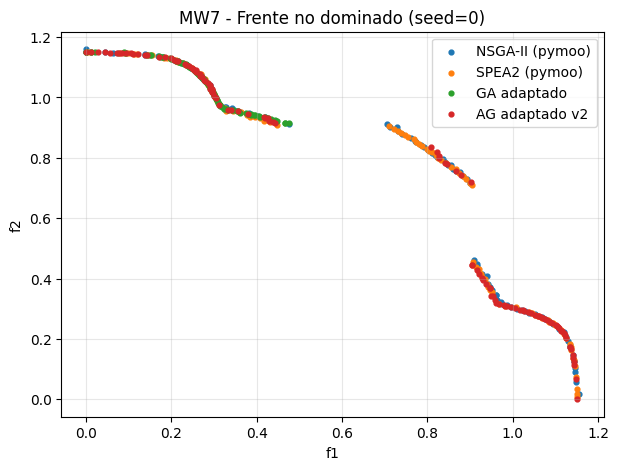

In [53]:
seed = 0

my = evolve_my_mo(seed=seed)
ag_2 = evolve_my_mo_v2(seed=seed)
ns = run_nsga2(seed=seed)
sp = run_spea2(seed=seed)

plt.figure(figsize=(7,5))
plt.scatter(ns["F_nd"][:,0], ns["F_nd"][:,1], s=12, label="NSGA-II (pymoo)")
plt.scatter(sp["F_nd"][:,0], sp["F_nd"][:,1], s=12, label="SPEA2 (pymoo)")
plt.scatter(my["F_nd"][:,0], my["F_nd"][:,1], s=12, label="GA adaptado")
plt.scatter(ag_2["F_nd"][:,0], ag_2["F_nd"][:,1], s=12, label="AG adaptado v2")
plt.xlabel("f1")
plt.ylabel("f2")
plt.title("MW7 - Frente no dominado (seed=0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Métricas finales

Comparamos nuestros dos algoritmos genéticos con NSGA-II y SPEA2.

In [54]:
ref_point = np.array([1.2, 1.2])
rows = []

for seed in range(10):
    ag = evolve_my_mo(seed=seed)
    ag_2 = evolve_my_mo_v2(seed=seed)
    ns = run_nsga2(seed)
    sp = run_spea2(seed)

    hv_ag, spr_ag, spa_ag = calculate_metrics(ag["F_nd"], ref_point)
    hv_ag2, spr_ag2, spa_ag2 = calculate_metrics(ag_2["F_nd"], ref_point)
    hv_n,  spr_n,  spa_n  = calculate_metrics(ns["F_nd"], ref_point)
    hv_s,  spr_s,  spa_s  = calculate_metrics(sp["F_nd"], ref_point)

    rows.append({
        "seed": seed,
        "HV_AG": hv_ag, "SPR_AG": spr_ag, "SPA_AG": spa_ag,
        "HV_AG2": hv_ag2, "SPR_AG2": spr_ag2, "SPA_AG2": spa_ag2,
        "HV_NSGA2": hv_n, "SPR_NSGA2": spr_n, "SPA_NSGA2": spa_n,
        "HV_SPEA2": hv_s, "SPR_SPEA2": spr_s, "SPA_SPEA2": spa_s
    })

df = pd.DataFrame(rows)
df


,seed,HV_AG,SPR_AG,SPA_AG,HV_AG2,SPR_AG2,SPA_AG2,HV_NSGA2,SPR_NSGA2,SPA_NSGA2,HV_SPEA2,SPR_SPEA2,SPA_SPEA2
0,0,0.273646,0.356156,0.003031,0.483322,1.150390,0.008236,0.485366,1.148626,0.010377,0.489135,1.143533,0.011289
1,1,0.268734,0.339781,0.003396,0.491877,1.150691,0.007098,0.481497,1.142147,0.010076,0.474032,1.154737,0.012029
2,2,0.277972,0.345386,0.003401,0.474553,1.150097,0.007013,0.483927,1.147639,0.010861,0.483378,1.130135,0.011297
3,3,0.467416,1.034257,0.008993,0.468210,1.150202,0.006334,0.484740,1.146236,0.010780,0.482797,1.138824,0.011018
4,4,0.261715,0.364809,0.003509,0.471971,1.150309,0.006259,0.465691,1.146128,0.008506,0.480270,1.142831,0.011114
5,5,0.270094,0.335748,0.002776,0.490649,1.150343,0.007268,0.486027,1.136450,0.010540,0.468744,1.162223,0.008448
6,6,0.066191,0.059986,0.000480,0.484783,1.150929,0.007187,0.477643,1.147530,0.008517,0.461806,1.032467,0.007241
7,7,0.361226,0.761768,0.006761,0.492803,1.151811,0.007051,0.480449,1.143449,0.011413,0.483325,1.142132,0.009867
8,8,0.453994,1.026942,0.010047,0.470699,1.152235,0.005547,0.263111,0.124534,0.001371,0.265547,0.152484,0.001671
9,9,0.280189,0.354129,0.002827,0.471239,1.150179,0.006530,0.477383,1.147449,0.010479,0.472427,1.157937,0.011743


In [55]:
summary_hv_spa = df[[
    "HV_AG", "SPA_AG",
	"HV_AG2", "SPA_AG2",
    "HV_NSGA2", "SPA_NSGA2",
    "HV_SPEA2", "SPA_SPEA2"
]].agg(["mean", "std"])

summary_hv_spa

,HV_AG,SPA_AG,HV_AG2,SPA_AG2,HV_NSGA2,SPA_NSGA2,HV_SPEA2,SPA_SPEA2
mean,0.298118,0.004522,0.480011,0.006852,0.458583,0.009292,0.456146,0.009572
std,0.113054,0.003047,0.009711,0.000727,0.068942,0.002942,0.067466,0.003169


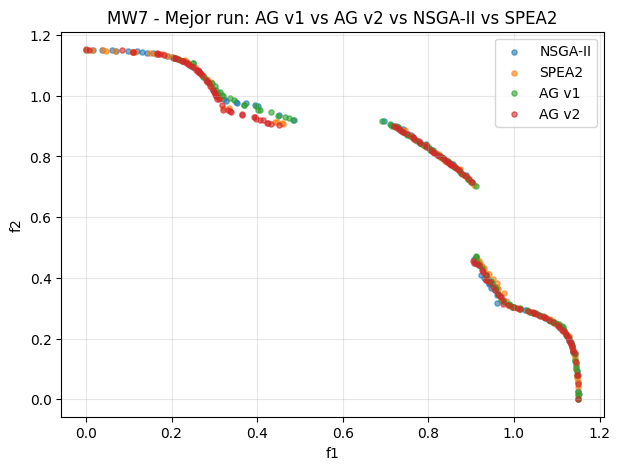

In [57]:
best_seed_ag  = int(df.loc[df["HV_AG"].idxmax(), "seed"])
best_seed_ag2 = int(df.loc[df["HV_AG2"].idxmax(), "seed"])

my   = evolve_my_mo(seed=best_seed_ag)
ag_2 = evolve_my_mo_v2(seed=best_seed_ag2)

ns = run_nsga2(seed=best_seed_ag2)   # o el mismo seed que uses para comparar
sp = run_spea2(seed=best_seed_ag2)

plt.figure(figsize=(7,5))
plt.scatter(ns["F_nd"][:,0], ns["F_nd"][:,1], s=14, alpha=0.6, label="NSGA-II")
plt.scatter(sp["F_nd"][:,0], sp["F_nd"][:,1], s=14, alpha=0.6, label="SPEA2")
plt.scatter(my["F_nd"][:,0], my["F_nd"][:,1], s=14, alpha=0.6, label="AG v1")
plt.scatter(ag_2["F_nd"][:,0], ag_2["F_nd"][:,1], s=14, alpha=0.6, label="AG v2")
plt.xlabel("f1"); plt.ylabel("f2")
plt.title("MW7 - Mejor run: AG v1 vs AG v2 vs NSGA-II vs SPEA2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Conclusiones

Estamso contentos con los resultados optenidos, nos quedamos con la segunda versión ya que presenta mejores resultados.

El AG inicial presenta el peor comportamiento global, con un hipervolumen medio bajo y alta variabilidad, lo que indica una convergencia inestable. La versión mejorada del algoritmo (AG2) incrementa de forma clara el hipervolumen medio y reduce la desviación estándar, mostrando una mejor convergencia y mayor estabilidad. Tanto NSGA-II como SPEA2 obtienen valores de hipervolumen similares entre sí, ligeramente inferiores a AG2, pero con mayor dispersión y peor espaciado medio. 

En conjunto, los resultados indican que la incorporación de elitismo y operadores continuos avanzados permite al AG propuesto igualar y superar el rendimiento de los algoritmos de referencia.